# EfficientNetV2 with tf-hub


<table class="tfo-notebook-buttons" align="left">
<td>
  <a target="_blank"  href="https://github.com/google/automl/blob/master/efficientnetv2/tfhub.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on github
  </a>
</td><td>
  <a target="_blank"  href="https://colab.sandbox.google.com/github/google/automl/blob/master/efficientnetv2/tfhub.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td><td>
    <!----<a href="https://tfhub.dev/google/collections/image/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />TF Hub models</a>--->
  </td>
</table>

## 1.Introduction

[EfficientNetV2](https://arxiv.org/abs/2104.00298) is a family of classification models, with better accuracy, smaller size, and faster speed than previous models.


This doc describes some examples with EfficientNetV2 tfhub. For more details, please visit the official code: https://github.com/google/automl/tree/master/efficientnetv2

## 2.Select the TF2 SavedModel module to use

In [97]:
!pip install matplotlib numpy matplotlib opencv-python tqdm tensorflow_hub sklearn seaborn webdataset

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 45 kB 1.8 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
strategy = tf.distribute.TPUStrategy(cluster_resolver)

print('TF version:', tf.__version__)
print('Hub version:', hub.__version__)
print('Phsical devices:', tf.config.list_physical_devices())

def get_hub_url_and_isize(model_name, ckpt_type, hub_type):
  if ckpt_type == '1k':
    ckpt_type = ''  # json doesn't support empty string
  else:
    ckpt_type = '-' + ckpt_type  # add '-' as prefix
  
  hub_url_map = {
    'efficientnetv2-b0': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b0/{hub_type}',
    'efficientnetv2-b1': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b1/{hub_type}',
    'efficientnetv2-b2': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b2/{hub_type}',
    'efficientnetv2-b3': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b3/{hub_type}',
    'efficientnetv2-s':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-s/{hub_type}',
    'efficientnetv2-m':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-m/{hub_type}',
    'efficientnetv2-l':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-l/{hub_type}',

    'efficientnetv2-b0-21k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b0-21k/{hub_type}',
    'efficientnetv2-b1-21k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b1-21k/{hub_type}',
    'efficientnetv2-b2-21k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b2-21k/{hub_type}',
    'efficientnetv2-b3-21k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b3-21k/{hub_type}',
    'efficientnetv2-s-21k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-s-21k/{hub_type}',
    'efficientnetv2-m-21k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-m-21k/{hub_type}',
    'efficientnetv2-l-21k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-l-21k/{hub_type}',
    'efficientnetv2-xl-21k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-xl-21k/{hub_type}',

    'efficientnetv2-b0-21k-ft1k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b0-21k-ft1k/{hub_type}',
    'efficientnetv2-b1-21k-ft1k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b1-21k-ft1k/{hub_type}',
    'efficientnetv2-b2-21k-ft1k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b2-21k-ft1k/{hub_type}',
    'efficientnetv2-b3-21k-ft1k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b3-21k-ft1k/{hub_type}',
    'efficientnetv2-s-21k-ft1k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-s-21k-ft1k/{hub_type}',
    'efficientnetv2-m-21k-ft1k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-m-21k-ft1k/{hub_type}',
    'efficientnetv2-l-21k-ft1k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-l-21k-ft1k/{hub_type}',
    'efficientnetv2-xl-21k-ft1k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-xl-21k-ft1k/{hub_type}',
      
    # efficientnetv1
    'efficientnet_b0': f'https://tfhub.dev/tensorflow/efficientnet/b0/{hub_type}/1',
    'efficientnet_b1': f'https://tfhub.dev/tensorflow/efficientnet/b1/{hub_type}/1',
    'efficientnet_b2': f'https://tfhub.dev/tensorflow/efficientnet/b2/{hub_type}/1',
    'efficientnet_b3': f'https://tfhub.dev/tensorflow/efficientnet/b3/{hub_type}/1',
    'efficientnet_b4': f'https://tfhub.dev/tensorflow/efficientnet/b4/{hub_type}/1',
    'efficientnet_b5': f'https://tfhub.dev/tensorflow/efficientnet/b5/{hub_type}/1',
    'efficientnet_b6': f'https://tfhub.dev/tensorflow/efficientnet/b6/{hub_type}/1',
    'efficientnet_b7': f'https://tfhub.dev/tensorflow/efficientnet/b7/{hub_type}/1',
  }
  
  image_size_map = {
    'efficientnetv2-b0': 224,
    'efficientnetv2-b1': 240,
    'efficientnetv2-b2': 260,
    'efficientnetv2-b3': 300,
    'efficientnetv2-s':  384,
    'efficientnetv2-m':  480,
    'efficientnetv2-l':  480,
    'efficientnetv2-xl':  512,
  
    'efficientnet_b0': 224,
    'efficientnet_b1': 240,
    'efficientnet_b2': 260,
    'efficientnet_b3': 300,
    'efficientnet_b4': 380,
    'efficientnet_b5': 456,
    'efficientnet_b6': 528,
    'efficientnet_b7': 600,
  }
  
  hub_url = hub_url_map.get(model_name + ckpt_type)
  image_size = image_size_map.get(model_name, 224)
  return hub_url, image_size


def get_imagenet_labels(filename):
  labels = []
  with open(filename, 'r') as f:
    for line in f:
      labels.append(line.split('\t')[1][:-1])  # split and remove line break.
  return labels


INFO:tensorflow:Initializing the TPU system: local


2021-10-01 11:22:51.084430: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
D1001 11:22:53.272909207   40620 ev_posix.cc:173]            Using polling engine: epollex
D1001 11:22:53.272976993   40620 lb_policy_registry.cc:42]   registering LB policy factory for "grpclb"
D1001 11:22:53.272983505   40620 lb_policy_registry.cc:42]   registering LB policy factory for "priority_experimental"
D1001 11:22:53.272986128   40620 lb_policy_registry.cc:42]   registering LB policy factory for "weighted_target_experimental"
D1001 11:22:53.272988285   40620 lb_policy_registry.cc:42]   registering LB policy factory for "pick_first"
D1001 11:22:53.272990640   40620 lb_policy_registry.cc:42]   registering LB pol

INFO:tensorflow:Clearing out eager caches
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/r

## 3.Inference with ImageNet 1k/2k checkpoints

## 3.1 ImageNet1k checkpoint

## 3.2 ImageNet21k checkpoint

## 4.Finetune with Flowers dataset.

Get hub_url and image_size


In [2]:
# Build model
import tensorflow_hub as hub
model_name = 'efficientnetv2-b0' #@param {type:'string'}
ckpt_type = '1k'   # @param ['21k', '21k-ft1k', '1k']
hub_type = 'feature-vector' # @param ['feature-vector']
batch_size =  256#@param {type:"integer"}
hub_url, image_size = get_hub_url_and_isize(model_name, ckpt_type, hub_type)

Get dataset

In [7]:
!git clone https://github.com/alex000kim/nsfw_data_scraper.git

Cloning into 'nsfw_data_scraper'...
remote: Enumerating objects: 200, done.
remote: Total 200 (delta 0), reused 0 (delta 0), pack-reused 200
Receiving objects: 100% (200/200), 8.27 MiB | 25.12 MiB/s, done.
Resolving deltas: 100% (103/103), done.


In [8]:
!cd nsfw_data_scraper/scripts; ./2_download_from_urls_.sh

Class: neutral. Total # of urls: 36837
Class: drawings. Total # of urls: 15566
Class: sexy. Total # of urls: 15957
Class: porn. Total # of urls: 57289
Class: hentai. Total # of urls: 4611


In [9]:
!cd nsfw_data_scraper/scripts; ./5_create_train_.sh

Copying image to the training folder
Removing very large (>10M) and very small (<6K) images
Number of files per class:
drawings: 12362
hentai: 2878
neutral: 34375
porn: 56281
sexy: 4555


In [4]:
!cd nsfw_data_scraper/scripts; ./7_clean_data_.sh

Copying image to the training folder
file /home/ozjuanpa/nsfw_data_scraper/data/train/neutral/94a2ecaf-28c3-4741-9895-d90c8ca77835.jpg is not a valid image file 
file /home/ozjuanpa/nsfw_data_scraper/data/train/neutral/6d59cf65-04c3-48b8-bfdf-7930d207f26a.jpg is not a valid image file 
file /home/ozjuanpa/nsfw_data_scraper/data/train/neutral/7eb195e9-8c33-4fc8-8e0d-9e7e6d98a534.jpg is not a valid image file 
file /home/ozjuanpa/nsfw_data_scraper/data/train/neutral/e0a80c4e-106e-404e-b855-34c050b585da.jpg is not a valid image file 
file /home/ozjuanpa/nsfw_data_scraper/data/train/neutral/ef45fc4b-3082-418a-a270-9fb0680bf89f.jpg is not a valid image file 
Corrupt JPEG data: 2648 extraneous bytes before marker 0xc4
file /home/ozjuanpa/nsfw_data_scraper/data/train/neutral/02d3d74e-f0ae-44e2-87c8-466b7a740b11.jpg is not a valid image file 
file /home/ozjuanpa/nsfw_data_scraper/data/train/neutral/31d186a7-27a4-4ea5-bf0f-6b1986be8164.jpg is not a valid image file 
file /home/ozjuanpa/nsfw_dat

In [25]:
data_dir = "nsfw_data_scraper/data/train"
    
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=(image_size, image_size),
                       batch_size=batch_size,
                       interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, shuffle=False, subset="validation", **dataflow_kwargs)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 26105 images belonging to 5 classes.
Found 104428 images belonging to 5 classes.


In [ ]:
!wget https://cdn.discordapp.com/attachments/891081957755224126/892619443472052234/nsfweffnetv2.h5

--2021-09-29 04:49:36--  https://cdn.discordapp.com/attachments/891081957755224126/892619443472052234/nsfweffnetv2.h5
Resolving cdn.discordapp.com (cdn.discordapp.com)... 162.159.135.233, 162.159.133.233, 162.159.130.233, ...
Connecting to cdn.discordapp.com (cdn.discordapp.com)|162.159.135.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48056536 (46M) [application/octet-stream]
Saving to: ‘nsfweffnetv2.h5’

nsfweffnetv2.h5     100%[===================>]  45.83M  77.7MB/s    in 0.6s    

2021-09-29 04:49:37 (77.7 MB/s) - ‘nsfweffnetv2.h5’ saved [48056536/48056536]



In [7]:
# Recreate the exact same model, including its weights and the optimizer
loaded_model = tf.keras.models.load_model('nsfweffnetv2-lion.h5',custom_objects={"KerasLayer":hub.KerasLayer})

# Show the model architecture
loaded_model.summary()

model = loaded_model


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              5919312   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 5,925,717
Trainable params: 5,865,109
Non-trainable params: 60,608
_________________________________________________________________


Training the model

In [8]:
from IPython.display import clear_output

class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [9]:
# whether to finetune the whole model or just the top layer.
do_fine_tuning = True #@param {type:"boolean"}
num_epochs = 1 #@param {type:"integer"}

tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=[image_size, image_size, 3]),
    hub.KerasLayer(hub_url, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None, image_size, image_size, 3))
model.summary()

!mkdir checkpoints
checkpoint_path = "checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)

model.save_weights(checkpoint_path.format(epoch=0))

model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=num_epochs, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    callbacks=[PlotLearning(),cp_callback],
    validation_steps=validation_steps).history

model.save("nsfweffnetv2-lion.h5")

hist

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              5919312   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 5,925,717
Trainable params: 5,865,109
Non-trainable params: 60,608
_________________________________________________________________
mkdir: cannot create directory ‘checkpoints’: File exists


tcmalloc: large alloc 3699605504 bytes == 0x1e268a000 @  0x7fe99249b680 0x7fe9924bc824 0x7fe7599a0904 0x7fe75bb11210 0x7fe75bb11c46 0x7fe75bc5e29e 0x7fe75bc5fb89 0x7fe75bc60847 0x7fe75bd85c6a 0x7fe75bd86316 0x7fe75bd87183 0x7fe7634822e9 0x7fe763795e65 0x7fe763793b37 0x7fe7637771ef 0x7fe992270609 0x7fe9923ac293


  1/407 [..............................] - ETA: 3:29:50 - loss: 1.6464 - accuracy: 0.2109

tcmalloc: large alloc 3699605504 bytes == 0x386a6a000 @  0x7fe99249b680 0x7fe9924bc824 0x7fe7599a0904 0x7fe75bb11210 0x7fe75bb11c46 0x7fe75bc5e29e 0x7fe75bc5fb89 0x7fe75bc60847 0x7fe75bd85c6a 0x7fe75bd86316 0x7fe75bd87183 0x7fe7634822e9 0x7fe763795e65 0x7fe763793b37 0x7fe7637771ef 0x7fe992270609 0x7fe9923ac293


  2/407 [..............................] - ETA: 2:27:07 - loss: 1.6421 - accuracy: 0.2051

tcmalloc: large alloc 3699605504 bytes == 0x1e268a000 @  0x7fe99249b680 0x7fe9924bc824 0x7fe7599a0904 0x7fe75bb11210 0x7fe75bb11c46 0x7fe75bc5e29e 0x7fe75bc5fb89 0x7fe75bc60847 0x7fe75bd85c6a 0x7fe75bd86316 0x7fe75bd87183 0x7fe7634822e9 0x7fe763795e65 0x7fe763793b37 0x7fe7637771ef 0x7fe992270609 0x7fe9923ac293


  3/407 [..............................] - ETA: 2:26:07 - loss: 1.6267 - accuracy: 0.2292

tcmalloc: large alloc 3699605504 bytes == 0x242dfe000 @  0x7fe99249b680 0x7fe9924bc824 0x7fe7599a0904 0x7fe75bb11210 0x7fe75bb11c46 0x7fe75bc5e29e 0x7fe75bc5fb89 0x7fe75bc60847 0x7fe75bd85c6a 0x7fe75bd86316 0x7fe75bd87183 0x7fe7634822e9 0x7fe763795e65 0x7fe763793b37 0x7fe7637771ef 0x7fe992270609 0x7fe9923ac293


  4/407 [..............................] - ETA: 2:20:35 - loss: 1.6202 - accuracy: 0.2354

tcmalloc: large alloc 3699605504 bytes == 0x242dfe000 @  0x7fe99249b680 0x7fe9924bc824 0x7fe7599a0904 0x7fe75bb11210 0x7fe75bb11c46 0x7fe75bc5e29e 0x7fe75bc5fb89 0x7fe75bc60847 0x7fe75bd85c6a 0x7fe75bd86316 0x7fe75bd87183 0x7fe7634822e9 0x7fe763795e65 0x7fe763793b37 0x7fe7637771ef 0x7fe992270609 0x7fe9923ac293


  5/407 [..............................] - ETA: 2:20:08 - loss: 1.6047 - accuracy: 0.2547

tcmalloc: large alloc 3699605504 bytes == 0x242dfe000 @  0x7fe99249b680 0x7fe9924bc824 0x7fe7599a0904 0x7fe75bb11210 0x7fe75bb11c46 0x7fe75bc5e29e 0x7fe75bc5fb89 0x7fe75bc60847 0x7fe75bd85c6a 0x7fe75bd86316 0x7fe75bd87183 0x7fe7634822e9 0x7fe763795e65 0x7fe763793b37 0x7fe7637771ef 0x7fe992270609 0x7fe9923ac293


  6/407 [..............................] - ETA: 2:16:58 - loss: 1.5920 - accuracy: 0.2650

tcmalloc: large alloc 3699605504 bytes == 0x242dfe000 @  0x7fe99249b680 0x7fe9924bc824 0x7fe7599a0904 0x7fe75bb11210 0x7fe75bb11c46 0x7fe75bc5e29e 0x7fe75bc5fb89 0x7fe75bc60847 0x7fe75bd85c6a 0x7fe75bd86316 0x7fe75bd87183 0x7fe7634822e9 0x7fe763795e65 0x7fe763793b37 0x7fe7637771ef 0x7fe992270609 0x7fe9923ac293


  7/407 [..............................] - ETA: 2:15:50 - loss: 1.5692 - accuracy: 0.2907

tcmalloc: large alloc 3699605504 bytes == 0x242dfe000 @  0x7fe99249b680 0x7fe9924bc824 0x7fe7599a0904 0x7fe75bb11210 0x7fe75bb11c46 0x7fe75bc5e29e 0x7fe75bc5fb89 0x7fe75bc60847 0x7fe75bd85c6a 0x7fe75bd86316 0x7fe75bd87183 0x7fe7634822e9 0x7fe763795e65 0x7fe763793b37 0x7fe7637771ef 0x7fe992270609 0x7fe9923ac293


  8/407 [..............................] - ETA: 2:13:40 - loss: 1.5455 - accuracy: 0.3145

tcmalloc: large alloc 3699605504 bytes == 0x242dfe000 @  0x7fe99249b680 0x7fe9924bc824 0x7fe7599a0904 0x7fe75bb11210 0x7fe75bb11c46 0x7fe75bc5e29e 0x7fe75bc5fb89 0x7fe75bc60847 0x7fe75bd85c6a 0x7fe75bd86316 0x7fe75bd87183 0x7fe7634822e9 0x7fe763795e65 0x7fe763793b37 0x7fe7637771ef 0x7fe992270609 0x7fe9923ac293


  9/407 [..............................] - ETA: 2:11:58 - loss: 1.5273 - accuracy: 0.3398

tcmalloc: large alloc 3699605504 bytes == 0x386a6a000 @  0x7fe99249b680 0x7fe9924bc824 0x7fe7599a0904 0x7fe75bb11210 0x7fe75bb11c46 0x7fe75bc5e29e 0x7fe75bc5fb89 0x7fe75bc60847 0x7fe75bd85c6a 0x7fe75bd86316 0x7fe75bd87183 0x7fe7634822e9 0x7fe763795e65 0x7fe763793b37 0x7fe7637771ef 0x7fe992270609 0x7fe9923ac293


 10/407 [..............................] - ETA: 2:11:50 - loss: 1.5089 - accuracy: 0.3602

tcmalloc: large alloc 3699605504 bytes == 0x386a6a000 @  0x7fe99249b680 0x7fe9924bc824 0x7fe7599a0904 0x7fe75bb11210 0x7fe75bb11c46 0x7fe75bc5e29e 0x7fe75bc5fb89 0x7fe75bc60847 0x7fe75bd85c6a 0x7fe75bd86316 0x7fe75bd87183 0x7fe7634822e9 0x7fe763795e65 0x7fe763793b37 0x7fe7637771ef 0x7fe992270609 0x7fe9923ac293


 17/407 [>.............................] - ETA: 2:08:05 - loss: 1.3714 - accuracy: 0.4715

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:2855: DecompressionBombWarning: Image size (111759720 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


 97/407 [======>.......................] - ETA: 1:39:04 - loss: 0.9587 - accuracy: 0.7330

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:2855: DecompressionBombWarning: Image size (97794746 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


109/407 [=======>......................] - ETA: 1:35:26 - loss: 0.9335 - accuracy: 0.7463

KeyboardInterrupt: 

In [26]:
Y_pred = model.predict(valid_generator)

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:2855: DecompressionBombWarning: Image size (143085600 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Confusion Matrix


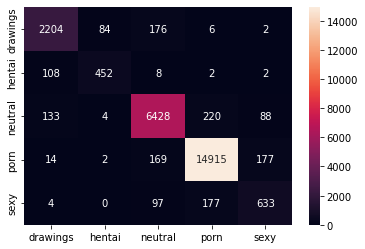

Classification Report
              precision    recall  f1-score   support

    drawings       0.89      0.89      0.89      2472
      hentai       0.83      0.79      0.81       572
     neutral       0.93      0.94      0.93      6873
        porn       0.97      0.98      0.97     15277
        sexy       0.70      0.69      0.70       911

    accuracy                           0.94     26105
   macro avg       0.87      0.86      0.86     26105
weighted avg       0.94      0.94      0.94     26105



In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def get_class_string_from_index(index):
    for class_string, class_index in valid_generator.class_indices.items():
        if class_index == index:
          return class_string

y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
confmatrix = confusion_matrix(valid_generator.classes, y_pred)
target_names = list(map(lambda x: get_class_string_from_index(x), range(5)))

g = sns.heatmap(confmatrix,annot=confmatrix,fmt="d")
g.set(xticklabels=target_names,yticklabels=target_names)
plt.show()
print('Classification Report')

print(classification_report(valid_generator.classes, y_pred, target_names=target_names))

In [ ]:
import webdataset as wds
from webdataset import multi
import cv2
from tqdm import tqdm 
from PIL import Image
import uuid

dataset = wds.WebDataset("http://3080.rom1504.fr/cah/laion400m_porn_data/00002.tar").decode("rgb").to_tuple("jpg", "json")
dataloader = multi.MultiLoader(dataset, workers=16)

keys = set()

for i,stuff in tqdm(enumerate(dataloader)):
    meta = stuff[1]
    if meta["key"] in keys:
        continue
    keys.add(meta["key"])
    width = meta["original_width"]
    height = meta["original_height"]
    if width > height:
        finalheight = (height/width)*255
        whitespace = 255 - finalheight
        barsize = int(whitespace/2)
        orimage = stuff[0][barsize+1:255-barsize,:,:]    
    else:
        finalwidth = (width/height)*255
        whitespace = 255 - finalwidth
        barsize = int(whitespace/2)
        orimage = stuff[0][:,barsize+1:255-barsize,:]
    image = orimage
    image = tf.image.resize(image,[image_size,image_size])
    prediction_scores = model.predict(np.expand_dims(image, axis=0))
    predicted_index = np.argmax(prediction_scores)
    pl = get_class_string_from_index(predicted_index)
    dist = tf.nn.softmax(prediction_scores[0])
    if dist[3] > 0.065:
        #print(meta)
        #for i in range(5):
        #    print(get_class_string_from_index(i),dist[i].numpy())
        #print(pl)
        #plt.imshow(image)
        #plt.show()
        im = Image.fromarray((orimage * 255).astype(np.uint8))
        im.save(f"laiondata/porn/{uuid.uuid4()}.jpeg")
    

105636it [10:04, 196.18it/s]

71it [00:09, 27.21it/s]

drawings 0.044065334
hentai 0.05187518
neutral 0.26134703
porn 0.40730307
sexy 0.23540935
porn


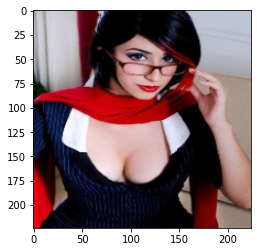

101it [00:10, 32.20it/s]

drawings 0.015222234
hentai 0.054108012
neutral 0.0063031646
porn 0.54195654
sexy 0.38241005
porn


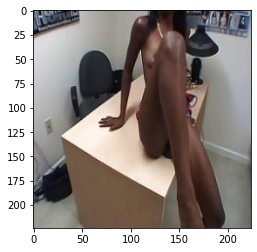

533it [00:15, 161.62it/s]

drawings 0.006837133
hentai 0.020366747
neutral 0.008534509
porn 0.51944816
sexy 0.44481346
porn


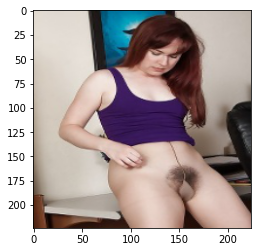

725it [00:16, 158.78it/s]

drawings 0.063529775
hentai 0.077706926
neutral 0.3805351
porn 0.28786844
sexy 0.19035976
neutral


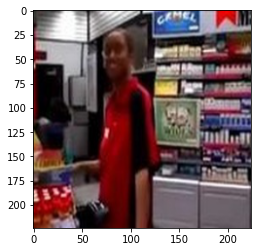

933it [00:18, 163.48it/s]

drawings 0.021861026
hentai 0.024488324
neutral 0.09734447
porn 0.13227491
sexy 0.7240313
sexy


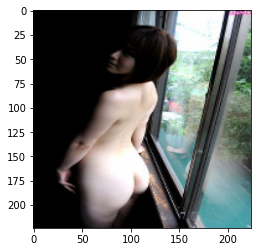

1413it [00:21, 183.55it/s]

drawings 0.04586375
hentai 0.061781134
neutral 0.18469656
porn 0.27847078
sexy 0.42918777
sexy


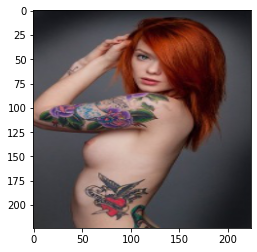

2277it [00:25, 191.72it/s]

drawings 0.011539797
hentai 0.035153322
neutral 0.013923831
porn 0.7591293
sexy 0.18025376
porn


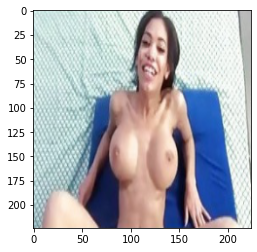

2437it [00:26, 178.69it/s]

drawings 0.018183345
hentai 0.050371353
neutral 0.36851558
porn 0.29634473
sexy 0.26658502
neutral


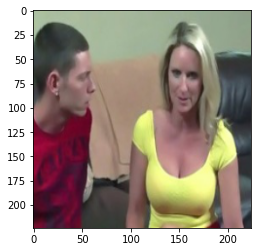

2757it [00:28, 190.92it/s]

drawings 0.020553952
hentai 0.037544627
neutral 0.034643587
porn 0.51161075
sexy 0.39564714
porn


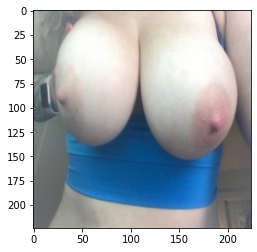

3253it [00:31, 205.14it/s]

drawings 0.017335508
hentai 0.048313685
neutral 0.059800006
porn 0.32211292
sexy 0.5524379
sexy


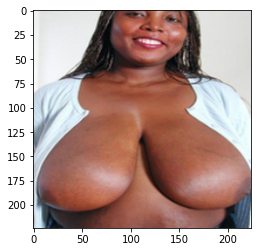

3333it [00:31, 174.87it/s]

drawings 0.07788824
hentai 0.040830072
neutral 0.46990776
porn 0.20093226
sexy 0.21044165
neutral


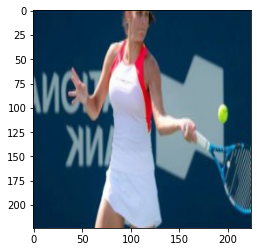

3589it [00:33, 194.47it/s]

drawings 0.03611855
hentai 0.035877876
neutral 0.17640097
porn 0.21031915
sexy 0.5412835
sexy


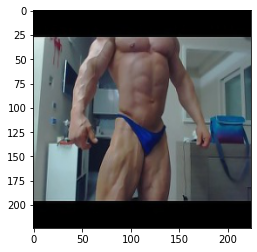

4357it [00:37, 205.84it/s]

drawings 0.028410546
hentai 0.05947451
neutral 0.037195213
porn 0.45394892
sexy 0.42097086
porn


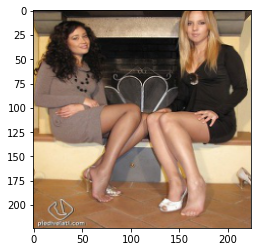

4757it [00:39, 200.53it/s]

drawings 0.016530529
hentai 0.022403395
neutral 0.07962237
porn 0.665465
sexy 0.21597871
porn


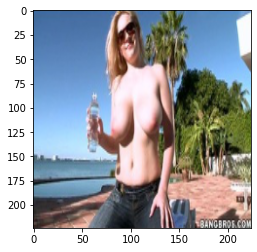

4901it [00:40, 184.21it/s]

drawings 0.034345172
hentai 0.03149201
neutral 0.20505142
porn 0.5170455
sexy 0.21206585
porn


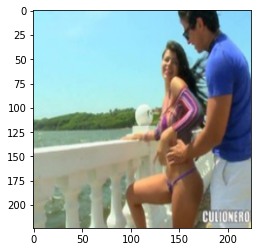

4949it [00:40, 158.98it/s]

drawings 0.012944759
hentai 0.01780938
neutral 0.032748494
porn 0.7091736
sexy 0.2273237
porn


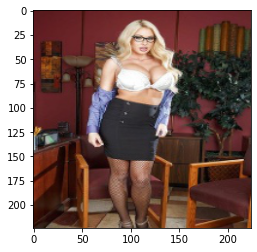

4966it [00:40, 129.87it/s]

drawings 0.013371656
hentai 0.065884046
neutral 0.031321913
porn 0.57294375
sexy 0.3164787
porn


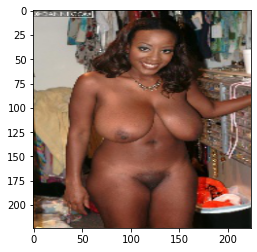

5045it [00:41, 149.33it/s]

drawings 0.020638997
hentai 0.030721787
neutral 0.047342736
porn 0.57800084
sexy 0.32329568
porn


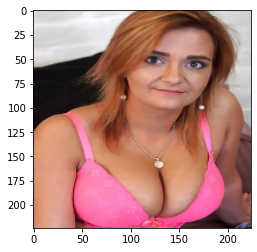

5717it [00:44, 197.92it/s]

drawings 0.021378364
hentai 0.0330506
neutral 0.024269976
porn 0.64761025
sexy 0.27369088
porn


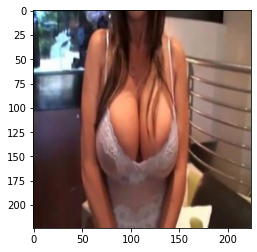

5893it [00:45, 189.33it/s]

drawings 0.030337745
hentai 0.07937516
neutral 0.06611324
porn 0.5977686
sexy 0.22640528
porn


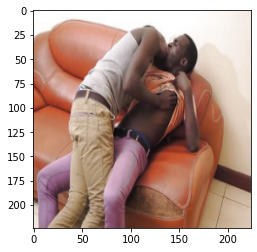

5989it [00:46, 176.01it/s]

drawings 0.024337137
hentai 0.064338244
neutral 0.031832926
porn 0.597449
sexy 0.28204265
porn


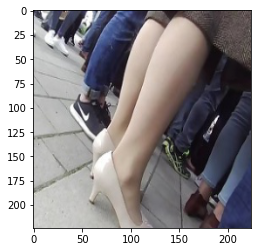

6037it [00:46, 155.17it/s]

drawings 0.11065229
hentai 0.05688193
neutral 0.42894918
porn 0.2108574
sexy 0.19265926
neutral


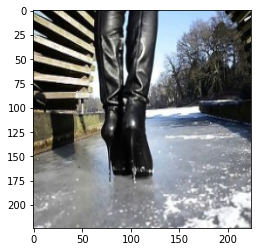

6149it [00:47, 165.28it/s]

drawings 0.02459547
hentai 0.03327209
neutral 0.010394222
porn 0.69180125
sexy 0.23993704
porn


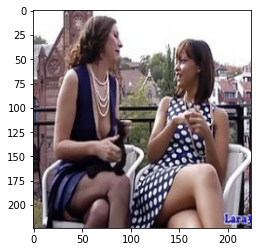

6453it [00:49, 193.41it/s]

drawings 0.021767814
hentai 0.024213254
neutral 0.010374917
porn 0.7625699
sexy 0.18107414
porn


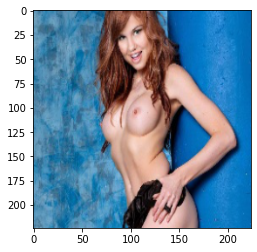

7285it [00:53, 205.70it/s]

drawings 0.030551005
hentai 0.038776353
neutral 0.059011873
porn 0.467383
sexy 0.40427774
porn


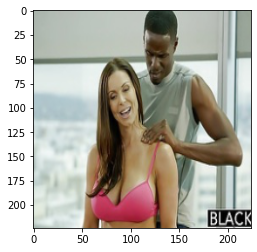

7477it [00:54, 196.43it/s]

drawings 0.034308676
hentai 0.1685579
neutral 0.031699505
porn 0.47458345
sexy 0.2908505
porn


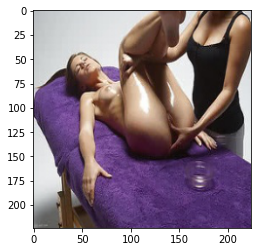

7765it [00:56, 198.88it/s]

drawings 0.031124841
hentai 0.05562479
neutral 0.10383845
porn 0.3330195
sexy 0.47639245
sexy


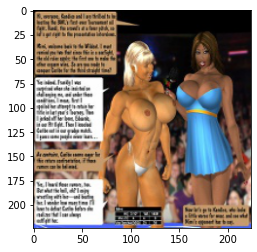

8085it [00:58, 184.01it/s]

drawings 0.035147686
hentai 0.039685365
neutral 0.02263683
porn 0.688433
sexy 0.21409717
porn


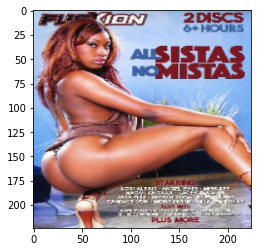

8104it [00:58, 142.65it/s]

drawings 0.04935159
hentai 0.048037443
neutral 0.099709556
porn 0.55845016
sexy 0.24445124
porn


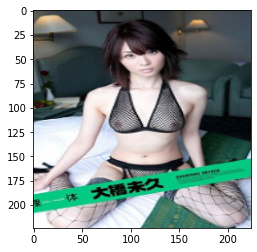

8517it [01:00, 185.86it/s]

drawings 0.031325303
hentai 0.09036608
neutral 0.170214
porn 0.38359734
sexy 0.32449722
porn


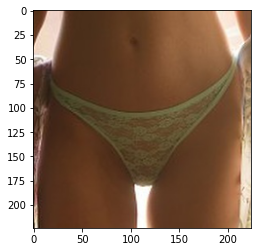

8661it [01:01, 178.69it/s]

drawings 0.03937258
hentai 0.028958809
neutral 0.40647143
porn 0.3121208
sexy 0.21307634
neutral


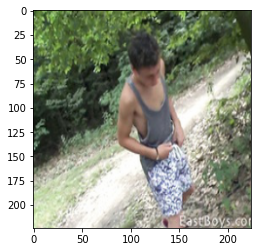

9077it [01:03, 198.71it/s]

drawings 0.07960489
hentai 0.096279934
neutral 0.02194184
porn 0.59337175
sexy 0.20880154
porn


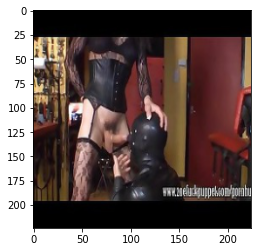

9097it [01:04, 160.48it/s]

drawings 0.048756365
hentai 0.036140863
neutral 0.14300102
porn 0.5410039
sexy 0.2310978
porn


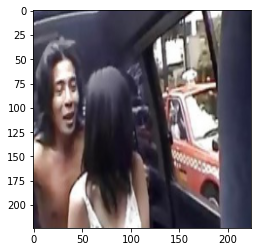

10053it [01:08, 202.01it/s]

drawings 0.07094794
hentai 0.048730083
neutral 0.17460951
porn 0.27639017
sexy 0.42932233
sexy


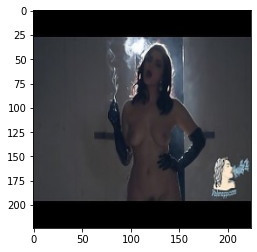

10165it [01:09, 184.56it/s]

drawings 0.029241502
hentai 0.07247534
neutral 0.078532435
porn 0.5240156
sexy 0.2957352
porn


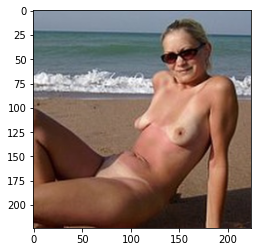

10341it [01:10, 189.48it/s]

drawings 0.019889103
hentai 0.018784635
neutral 0.59071994
porn 0.016584855
sexy 0.35402155
neutral


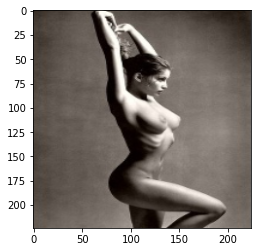

10581it [01:11, 196.44it/s]

drawings 0.013999749
hentai 0.03591891
neutral 0.019170878
porn 0.52611834
sexy 0.40479207
porn


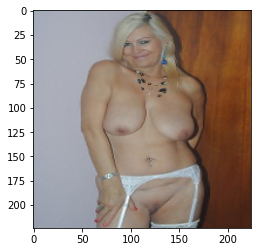

10741it [01:12, 189.00it/s]

drawings 0.018561343
hentai 0.032847717
neutral 0.015891138
porn 0.61399215
sexy 0.31870764
porn


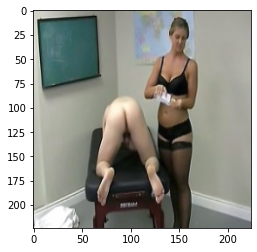

11157it [01:15, 202.18it/s]

drawings 0.015142728
hentai 0.056346226
neutral 0.03643993
porn 0.42520142
sexy 0.46686977
sexy


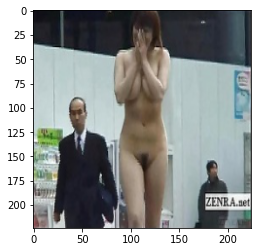

12133it [01:20, 193.34it/s]

drawings 0.08522696
hentai 0.049092516
neutral 0.058781117
porn 0.48237172
sexy 0.32452768
porn


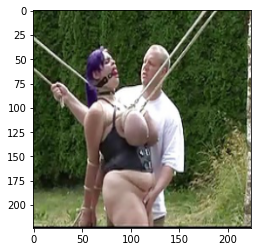

12213it [01:20, 170.69it/s]

drawings 0.2474967
hentai 0.03884134
neutral 0.43528044
porn 0.054383494
sexy 0.22399805
neutral


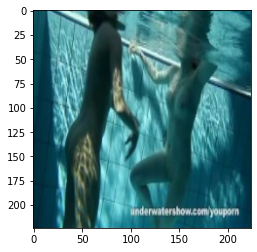

12245it [01:20, 142.33it/s]

drawings 0.03436689
hentai 0.053526323
neutral 0.25101933
porn 0.098042816
sexy 0.56304455
sexy


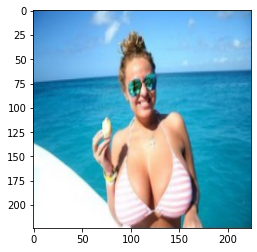

12741it [01:23, 201.59it/s]

drawings 0.030662496
hentai 0.024260612
neutral 0.030834658
porn 0.602921
sexy 0.3113212
porn


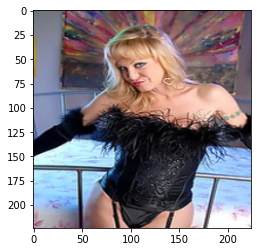

12837it [01:24, 178.37it/s]

drawings 0.027488768
hentai 0.056059092
neutral 0.06337338
porn 0.23681659
sexy 0.6162622
sexy


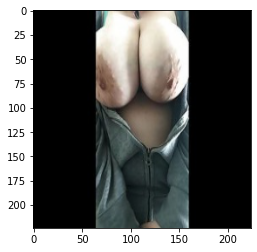

13685it [01:28, 199.79it/s]

drawings 0.096628755
hentai 0.1666556
neutral 0.046649918
porn 0.43997392
sexy 0.2500918
porn


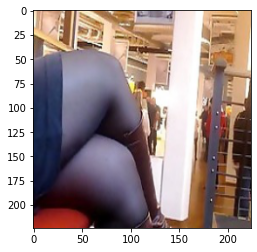

13877it [01:29, 188.25it/s]

drawings 0.17362215
hentai 0.048636176
neutral 0.35445252
porn 0.18157692
sexy 0.24171215
neutral


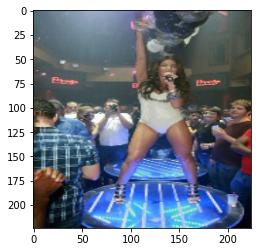

14965it [01:35, 202.74it/s]

drawings 0.016933553
hentai 0.01608854
neutral 0.024240516
porn 0.7382516
sexy 0.20448571
porn


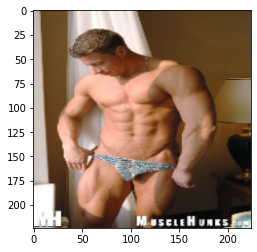

15349it [01:37, 203.13it/s]

drawings 0.03692431
hentai 0.066868305
neutral 0.015370885
porn 0.47622824
sexy 0.4046082
porn


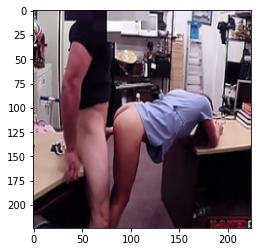

15557it [01:38, 198.13it/s]

drawings 0.040862713
hentai 0.034982853
neutral 0.07820246
porn 0.5451894
sexy 0.30076253
porn


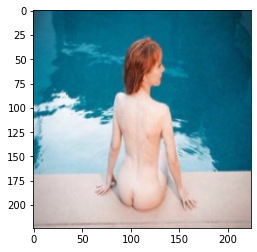

15909it [01:40, 202.96it/s]

drawings 0.020710532
hentai 0.043600522
neutral 0.014550353
porn 0.508507
sexy 0.4126316
porn


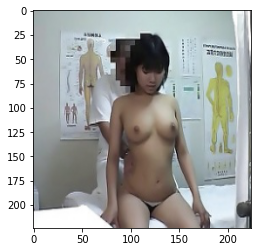

16101it [01:41, 176.78it/s]

drawings 0.041726932
hentai 0.0486083
neutral 0.018588325
porn 0.5305734
sexy 0.36050302
porn


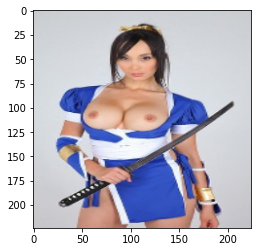

16149it [01:42, 150.03it/s]

drawings 0.0090348665
hentai 0.020300532
neutral 0.0042017233
porn 0.77149636
sexy 0.19496644
porn


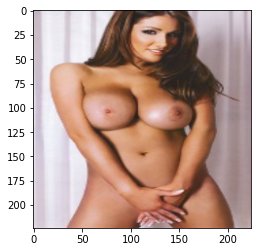

16661it [01:45, 190.17it/s]

drawings 0.015684947
hentai 0.075125955
neutral 0.02189058
porn 0.4386646
sexy 0.44863385
sexy


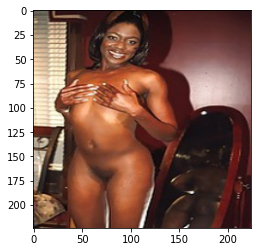

17253it [01:48, 191.31it/s]

drawings 0.01153265
hentai 0.02467879
neutral 0.03166024
porn 0.71862286
sexy 0.21350545
porn


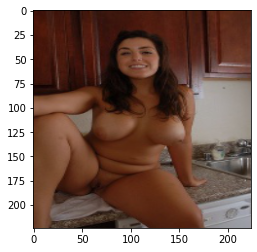

17605it [01:50, 194.41it/s]

drawings 0.063758776
hentai 0.19042626
neutral 0.044971503
porn 0.46954924
sexy 0.23129417
porn


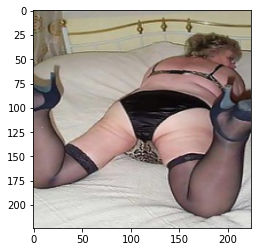

18021it [01:52, 195.27it/s]

drawings 0.016684145
hentai 0.027038317
neutral 0.56321615
porn 0.09393888
sexy 0.2991224
neutral


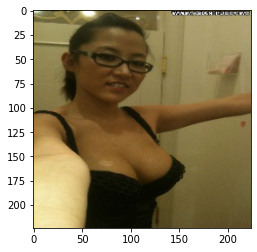

18041it [01:52, 156.78it/s]

drawings 0.015413277
hentai 0.03862889
neutral 0.017067477
porn 0.7191647
sexy 0.20972559
porn


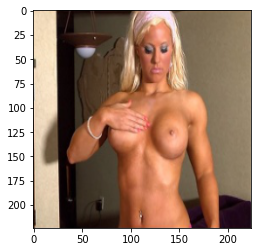

18309it [01:54, 190.56it/s]

drawings 0.017205067
hentai 0.12343992
neutral 0.27403623
porn 0.11383919
sexy 0.47147956
sexy


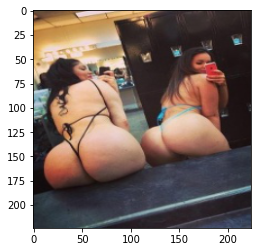

18538it [01:55, 192.23it/s]

drawings 0.034506004
hentai 0.02808386
neutral 0.008693084
porn 0.7327278
sexy 0.19598931
porn


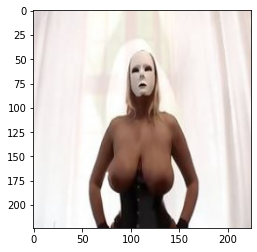

18917it [01:57, 190.07it/s]

drawings 0.035823096
hentai 0.028025836
neutral 0.30312684
porn 0.4103562
sexy 0.22266804
porn


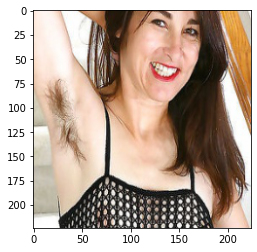

19125it [01:58, 187.43it/s]

drawings 0.011438625
hentai 0.042367388
neutral 0.11348596
porn 0.56724226
sexy 0.26546583
porn


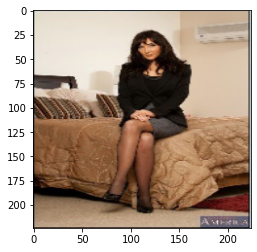

19269it [01:59, 181.27it/s]

drawings 0.01931817
hentai 0.024603033
neutral 0.022417111
porn 0.72977
sexy 0.20389162
porn


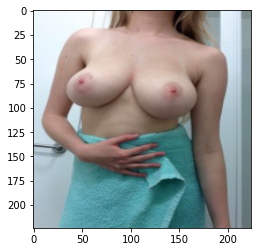

19393it [02:00, 167.87it/s]

drawings 0.012000416
hentai 0.06267669
neutral 0.042278796
porn 0.0513173
sexy 0.83172673
sexy


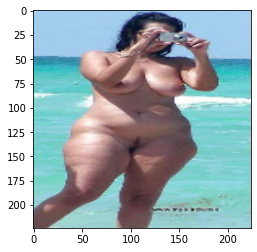

19621it [02:02, 149.41it/s]

drawings 0.017271519
hentai 0.040831868
neutral 0.15306582
porn 0.36046633
sexy 0.42836446
sexy


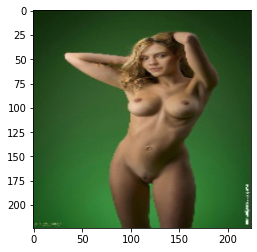

19813it [02:03, 147.99it/s]

drawings 0.011363657
hentai 0.018096827
neutral 0.012610407
porn 0.6144782
sexy 0.34345093
porn


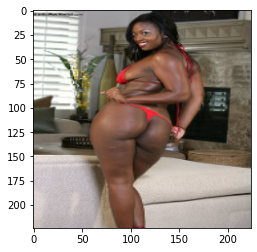

20005it [02:04, 137.46it/s]

drawings 0.03109343
hentai 0.027290108
neutral 0.06012496
porn 0.6283535
sexy 0.25313798
porn


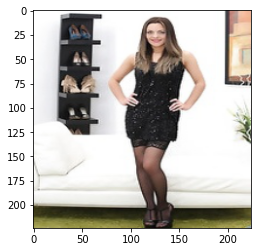

20125it [02:05, 160.27it/s]

drawings 0.023168601
hentai 0.06687083
neutral 0.12002696
porn 0.4257566
sexy 0.36417705
porn


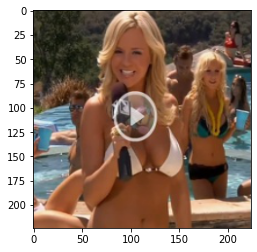

20533it [02:08, 151.61it/s]

drawings 0.031683747
hentai 0.07204823
neutral 0.1438206
porn 0.32822493
sexy 0.4242225
sexy


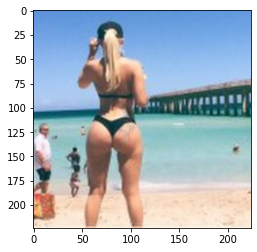

20615it [02:09, 146.37it/s]

drawings 0.019843778
hentai 0.028385865
neutral 0.02689545
porn 0.7203251
sexy 0.2045498
porn


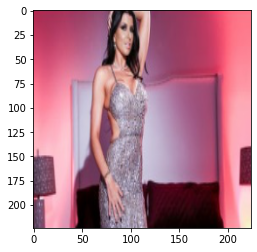

21413it [02:14, 168.14it/s]

drawings 0.06443456
hentai 0.082732216
neutral 0.024923807
porn 0.48683307
sexy 0.3410763
porn


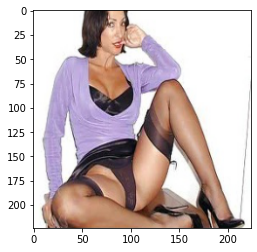

21445it [02:14, 144.22it/s]

drawings 0.03156068
hentai 0.03625804
neutral 0.048743267
porn 0.62872475
sexy 0.2547133
porn


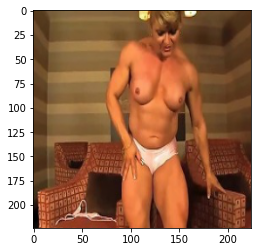

22949it [02:23, 194.79it/s]

drawings 0.05555261
hentai 0.12404547
neutral 0.20030862
porn 0.41325647
sexy 0.20683682
porn


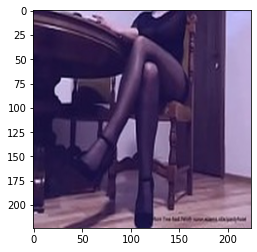

23141it [02:24, 188.09it/s]

drawings 0.015940107
hentai 0.039841797
neutral 0.04159005
porn 0.34234047
sexy 0.5602876
sexy


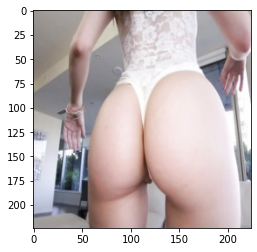

23333it [02:25, 186.29it/s]

drawings 0.07195829
hentai 0.04581469
neutral 0.060436215
porn 0.5937264
sexy 0.22806448
porn


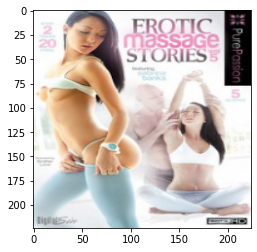

23653it [02:27, 191.56it/s]

drawings 0.034241613
hentai 0.068517834
neutral 0.045200296
porn 0.15218008
sexy 0.69986016
sexy


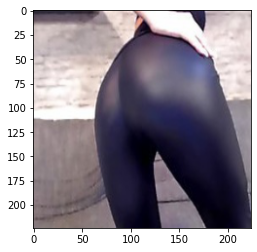

24132it [02:30, 160.52it/s]Process Process-154:
Process Process-149:
Process Process-145:
Process Process-152:
Process Process-146:
Process Process-155:
Process Process-157:
Process Process-156:
Process Process-151:
Process Process-150:
Process Process-153:
Process Process-158:
Process Process-159:
Process Process-160:
Process Process-148:
Process Process-147:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs

  File "/home/ozjuanpa/.local/lib/python3.8/site-packages/zmq/sugar/socket.py", line 547, in send
    return super(Socket, self).send(data, flags=flags, copy=copy, track=track)
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/ozjuanpa/.local/lib/python3.8/site-packages/zmq/sugar/socket.py", line 547, in send
    return super(Socket, self).send(data, flags=flags, copy=copy, track=track)
  File "zmq/backend/cython/socket.pyx", line 765, in zmq.backend.cython.socket.Socket.send
  File "zmq/backend/cython/socket.pyx", line 718, in zmq.backend.cython.socket.Socket.send
KeyboardInterrupt
  File "/home/ozjuanpa/.local/lib/python3.8/site-packages/zmq/sugar/socket.py", line 547, in send
    return super(Socket, self).send(data, flags=flags, copy=copy, tr

drawings 0.020769771
hentai 0.029146083
neutral 0.104078375
porn 0.11836054
sexy 0.7276452
sexy


KeyboardInterrupt: 

In [24]:
import webdataset as wds
from webdataset import multi
import cv2
from tqdm import tqdm 
from PIL import Image
import time
import uuid

dataset = wds.WebDataset("http://3080.rom1504.fr/cah/laion400m_porn_data/00006.tar").decode("rgb").to_tuple("jpg", "json")
dataloader = multi.MultiLoader(dataset, workers=16)

keys = set()

for i,stuff in tqdm(enumerate(dataloader)):
    meta = stuff[1]
    if meta["key"] in keys:
        continue
    keys.add(meta["key"])
    width = meta["original_width"]
    height = meta["original_height"]
    if width > height:
        finalheight = (height/width)*255
        whitespace = 255 - finalheight
        barsize = int(whitespace/2)
        orimage = stuff[0][barsize+1:255-barsize,:,:]    
    else:
        finalwidth = (width/height)*255
        whitespace = 255 - finalwidth
        barsize = int(whitespace/2)
        orimage = stuff[0][:,barsize+1:255-barsize,:]
    image = orimage
    image = tf.image.resize(image,[image_size,image_size])
    prediction_scores = model.predict(np.expand_dims(image, axis=0))
    predicted_index = np.argmax(prediction_scores)
    pl = get_class_string_from_index(predicted_index)
    dist = tf.nn.softmax(prediction_scores[0])
    if dist[4] < 0.18:
        continue
    for i in range(5):
        print(get_class_string_from_index(i),dist[i].numpy())
    print(pl)
    plt.imshow(image)
    plt.show()
    

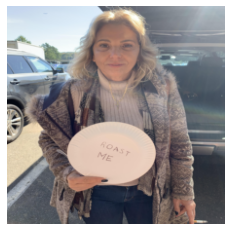

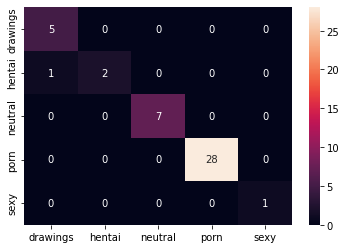

True label: neutral
Predicted label: neutral


KeyboardInterrupt: 

In [14]:
import seaborn as sns
from IPython.display import clear_output

conf_matrix = [ [ 0 for j in range(5) ] for i in range(5) ]

for i in range(len(valid_generator)):
  
  def get_class_string_from_index(index):
    for class_string, class_index in valid_generator.class_indices.items():
        if class_index == index:
          return class_string

  x, y = next(valid_generator)
  image = x[0, :, :, :]
  true_index = np.argmax(y[0])
  
  

  # Expand the validation image to (1, 224, 224, 3) before predicting the label
  prediction_scores = model.predict(np.expand_dims(image, axis=0))
  predicted_index = np.argmax(prediction_scores)
  tl = get_class_string_from_index(true_index)
  pl = get_class_string_from_index(predicted_index)
  conf_matrix[true_index][predicted_index] += 1
  alllabels = list(map(lambda x: get_class_string_from_index(x), range(5)))
  clear_output()
  plt.imshow(image)
  plt.axis('off')
  plt.show()
  g = sns.heatmap(conf_matrix,annot=conf_matrix)
  g.set(xticklabels=alllabels,yticklabels=alllabels)
  plt.show()
  print("True label: " + tl)
  print("Predicted label: " + pl)
  if tl in ["hentai","porn","sexy"] and pl in ["neutral","drawings"]:
    print("FALSE NEGATIVE")
  

In [ ]:
model.save("nsfweffnetv2.h5")

Finally, the trained model can be saved for deployment to TF Serving or TF Lite (on mobile) as follows.

In [ ]:
saved_model_path = f"/tmp/saved_flowers_model_{model_name}"
tf.saved_model.save(model, saved_model_path)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: /tmp/saved_flowers_model_efficientnetv2-b0/assets


INFO:tensorflow:Assets written to: /tmp/saved_flowers_model_efficientnetv2-b0/assets


## Optional: Deployment to TensorFlow Lite

[TensorFlow Lite](https://www.tensorflow.org/lite) for mobile. Here we also runs tflite file in the TF Lite Interpreter to examine the resulting quality.

In [ ]:
optimize_lite_model = True  #@param {type:"boolean"}
#@markdown Setting a value greater than zero enables quantization of neural network activations. A few dozen is already a useful amount.
num_calibration_examples = 81  #@param {type:"slider", min:0, max:1000, step:1}
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_generator for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open(f"/tmp/lite_flowers_model_{model_name}.tflite", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

Wrote optimized TFLite model of 7098720 bytes.


In [ ]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TF Lite interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [ ]:
#@markdown For rapid experimentation, start with a moderate number of examples.
num_eval_examples = 50  #@param {type:"slider", min:0, max:700}
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_generator
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TF Lite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TF Lite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))

TF Lite model agrees with original model on 49 of 50 examples (98%).
TF Lite model is accurate on 48 of 50 examples (96%).
